# Job Shop Scheduling by AI Planning: State Space Search

---

The **job shop scheduling** problem is a classic AI planning, scheduling and combinatorial optimisation problem. It has many real-world applications in Industry 4.0, such as intelligent supply chain management, manufacturing and cloud computing. 

In this tutorial, we will introduce how to solve job shop scheduling through AI planning, specifically using **state space search**.

## Car Manufacturing <a name = "problem"></a>

---

Let's consider a car manufacturing factory. It receives **jobs** to build cars. For the sake of simplicity, we consider that building a car consists of the following a **sequence** of three main **operations**:

1. **Add Engine**: This is to add the engine to the car by an **Engine Hoist**;
2. **Add Wheels**: This is to add the wheels to the car by a **Wheel Station**;
3. **Inspect**: After the car has been built, it has to be inspected by an **Inspector**.

<img src="img/car-manufacturing.png" width=400 />

Each operation of each job has a **duration (processing time)**, and the required **machine** to process it. There are two constraints that a job shop schedule must satisfy:

1. **Resource Constraint**: each machine can process at most one operation at a time.
2. **Precedence Constraint**: each operation cannot start processing until its precedent operation in the same job has been completed (e.g., `add_wheels` cannot start until `add_engine` is completed). The first operation of a job can be started at time 0 (the job is already at the shop floor).

The goal of job shop scheduling is to find a schedule with the minimal **makespan** (the completion time of the last completed job), subject to the above resource and precedence constraints.

Assuming that there are two jobs described as follows:

| Job | Operation | Machine |  Duration |
| --- | --------- | ------- |  --------- |
| 1   | `add_engine_1` | `engine_hoist` | 30 |
|     | `add_wheels_1` | `wheel_station` | 30 |
|     | `inspect_1` |    `inspector` | 10 |
| 2   | `add_engine_2` | `engine_hoist` | 60 |
|     | `add_wheels_2` | `wheel_station` | 15 |
|     | `inspect_2` |    `inspector` | 10 |

We create the machines and jobs in Python as follows. The operations are linked through the `next` variable.

In [1]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

job_1 = [
    {'name': 'add_engine_1', 'machine': 'engine_hoist', 'duration': 30, 'next': 'add_wheels_1'},
    {'name': 'add_wheels_1', 'machine': 'wheel_station', 'duration': 30, 'next': 'inspect_1'},
    {'name': 'inspect_1', 'machine': 'inspector', 'duration': 10, 'next': None}
]

job_2 = [
    {'name': 'add_engine_2', 'machine': 'engine_hoist', 'duration': 60, 'next': 'add_wheels_2'},
    {'name': 'add_wheels_2', 'machine': 'wheel_station', 'duration': 15, 'next': 'inspect_2'},
    {'name': 'inspect_2', 'machine': 'inspector', 'duration': 10, 'next': None}
]

jobs = [job_1, job_2]

Let's print the second operation of the second job, i.e., `add_wheels_2`.

In [2]:
print(job_2[1])

{'name': 'add_wheels_2', 'machine': 'wheel_station', 'duration': 15, 'next': 'inspect_2'}


Below shows the gantt chart of two possible feasible schedules. We can observe that the first schedule has a makespan of 115, while the second one has a makespan of 130.

<img src="img/schedule1.png" width=600 />

<img src="img/schedule2.png" width=600 />

The two schedules can be represented as follows. Each schedule consists of a sequence of operations with their start time for each machine.

In [3]:
schedule_1 = {
    'engine_hoist': [(job_1[0], 0), (job_2[0], 30)],
    'wheel_station': [(job_1[1], 30), (job_2[1], 90)],
    'inspector': [(job_1[2], 60), (job_2[2], 105)]
}

schedule_2 = {
    'engine_hoist': [(job_2[0], 0), (job_1[0], 60)],
    'wheel_station': [(job_2[1], 60), (job_1[1], 90)],
    'inspector': [(job_2[2], 75), (job_1[2], 120)]
}

The **makespan** of a schedule can be easily calculated by the completion time of the last operation of the last job. In this case, it is the last operation on `inspector`, since `inspect` is the last operation of each job.

In [4]:
# Calculate the makespan of a schedule
def makespan(schedule):
    last_finish_time = 0
    for machine_schedule in schedule.values():
        last_processing = machine_schedule[-1]
        machine_finish_time = last_processing[1] + last_processing[0]['duration']
        
        if machine_finish_time > last_finish_time:
            last_finish_time = machine_finish_time
            
    return last_finish_time

Let's calculate the makespan of `schedule_1` and `schedule_2`.

In [5]:
print(f'Schedule 1 makespan = {makespan(schedule_1)}')
print(f'Schedule 2 makespan = {makespan(schedule_2)}')

Schedule 1 makespan = 115
Schedule 2 makespan = 130


## State Space Search <a name="search"></a>

---

Following the AI planning paradigm, the **state space search** for schedules needs to define the (1) initial state, (2) goal states, and (3) set of actions. In addition, the search is in a job shop environment with a number of machines and jobs to be processed. To this end, we need to define **environment**, **state** and **action** for the state space search.

### Environment <a name='env'></a>

The job shop environment consists of the `machines` and `jobs` information. This is the static information that remain unchanged during the search. In other words, the environment stores the attributes that are not changed by the actions.

### State <a name="state"></a>

A job shop **state** should include the temporal states of each operation and each machine during the search, such as whether a machine is busy or idle, and when it will complete the current operation if it's busy, whether an operation is ready to be processed (i.e., its precedent operation has been completed) or not, etc. It should also include the current time and the schedule so far.

Here, we define the job shop **state** with the following attributes:

1. `machine_idle_time`: **the idle time of each machine**. If the idle time of a machine is earlier than the current time, then the machine is idle. Otherwise, the machine is busy with processing some operation. It will complete its operation and become idle again at its `machine_idle_time`. Initially, all the machines are idle, and their idle time are 0.
2. `operation_ready_time`: **the ready time of each operation**. Initially, the first operation of each job is ready, i.e., its ready time is 0. Other operations are not ready yet. Then, once an operation has been completed, the ready time of its next operation is updated with the completion time of the operation.
3. `schedule`: **the schedule so far**. Initially, the schedule is empty (no operation has been processed). A complete schedule includes the start and finish time of all the operations.
4. `completed`: **the list of completed operations**. Initially, no operation is completed. In a goal state, all the operations are completed.

For the above car manufacturing problem, we create the initial state as follows.

In [6]:
def create_init_state(machines, jobs):
    init_state = {
        "machine_idle_time": {},
        "operation_ready_time": {},
        "schedule": {},
        "completed": [] # no operation is completed initially
    }

    # Initially, the idle time of all the machines are 0.
    for m in machines:
        init_state["machine_idle_time"][m] = 0

    # Initially, only the first operation of each job is ready at time 0
    for job in jobs:
        init_state["operation_ready_time"][job[0]["name"]] = 0

    # Initially, the machine schedules are empty
    for m in machines:
        init_state["schedule"][m] = []
    
    return init_state

Let's generate an initial state and print the initial machine idle time and operation ready time.

In [7]:
init_state = create_init_state(machines, jobs)

print(f'Initial machine idle time: {init_state["machine_idle_time"]}')
print(f'Initial operation ready time: {init_state["operation_ready_time"]}')

Initial machine idle time: {'engine_hoist': 0, 'wheel_station': 0, 'inspector': 0}
Initial operation ready time: {'add_engine_1': 0, 'add_engine_2': 0}


We can see that initially all the three machines are idle at time 0, and only the first operations `add_engine` of the two jobs are ready at time 0.

### Action <a name="action"></a>

An **action** in the state space search is to **start processing** an `operation` by a `machine` at a specific `time`. 

For each action, the **precondition** (i.e., in which states the action is applicable) and **effect** (i.e., how the action updates the state when being applied) are given as follows.

#### Precondition

- `operation` is uncompleted, and is ready at `time`, i.e., `operation_ready_time[operation] <= time`.
- `machine` is idle at `time`, i.e., `machine_idle_time[machine] <= time`.

#### Effect

- `operation` becomes completed, i.e., `completed[operation] = True`.
- `machine` becomes busy, and its idle time is updated to `machine_idle_time[machine] = time + duration[operation]`.
- If `operation` is not the last operation in the job, then its next operation becomes ready once it is completed, i.e., `operation_ready_time[next[operation]] = time + duration[operation]`.

### Overall Search Algorithm <a name="overall"></a>

After designing the **state** and **action**, we now describe how to search for the best schedule in the state space.

Note that the space space can be seen as a graph, where each state is a node, and each action is an edge/link to connect the nodes/states. Here, we follow the general **graph search** process which maintains a **fringe** of states that represents the current frontier during the search process. At each step, we pick one state from the fringe (i.e., visit a branch) to continue the search. The search stops after all the possible solutions have been found, and the fringe becomes empty. 

<img src="img/jss-state-search.png" width=600 />

The pseudo code of the state space search can be described as follows.

```python
Create an initial state, best_state = None, best_makespan = infinity
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search by expanding a branch at each step
while fringe is not empty:
    Pick a state from fringe
    
    if state is a goal state:
        if the schedule of state has a smaller makespan than best_makespan:
            best_state = state, best_makespan = makespan
    
    Find the applicable actions in state
    
    for action in applicable_actions:
        Apply action to state to create next_state
        Add next_state into fringe

    remove state from fringe
    
return the schedule of best_state
```

### Find Applicable Actions in a State

During the search process, an important step is to find the applicable actions in a state. By definition, a process action includes three components: `operation`, `machine` and `time`. While the first two components `operation` and `machine` are relatively straightforward from the ready operations and idle machines, the processing start `time` is not trivially defined. Specifically, we can start processing an operation with a machine any time after the operation is ready and the machine is idle. For example, if `operation` is ready at time 30 and `machine` is idle at time 40, then we can start processing `operation` by `machine` any time after time 40 (e.g., 50, 60, etc). This leads to infinite number of applicable actions. 

To address this issue, we follow the common **non-delay** scheme, which means that no delay is allowed to process operations. In the above example where `operation` is ready at time 30 and `machine` is idle at time 40, there is ONLY one action starting at time 40 under the non-delay scheme.

> In a state, there is one applicable non-delay action for each ready operation, and its starting time is the maximum of the operation ready time and the machine idle time.

The code of the overall **state space search** algorithm is shown below.

In [8]:
# Import the copy library to generate new states conveniently
import copy

def state_space_search(machines, jobs):
    # Create the operation dictionary for state space search
    operations = {}
    for job in jobs:
        for op in job:
            operations[op['name']] = op

    # Initially, the best schedule is None (no schedule is found), and best makespan is infinity
    best_schedule = None
    best_makespan = float('inf')

    # Initially, the fringe has the initial state only
    init_state = create_init_state(machines, jobs)
    fringe = [init_state]

    while len(fringe) > 0:
        # Arbitrarily pick the first state in the fringe
        state = fringe[0] 

        # Check if the current state is a goal state
        if len(state["completed"]) == len(operations):
            # Calculate the makespan of the complete schedule
            new_makespan = makespan(state["schedule"])

            if new_makespan < best_makespan:
                best_schedule = state["schedule"]
                best_makespan = new_makespan

        # Each ready operation has a non-delay applicable action to process it.
        # Its start time is max[operation_ready_time, machine_idle_time].
        applicable_actions = []
        for opname in state["operation_ready_time"].keys():
            op = operations[opname]
            machine = op['machine']        
            time = state["operation_ready_time"][opname]        
            if time < state["machine_idle_time"][machine]:
                time = state["machine_idle_time"][machine]

            applicable_actions.append((op, time))

        # Expand the branches, each by an applicable action
        for a in applicable_actions:
            op = a[0] # action operation
            machine = op['machine'] # action machine
            time = a[1] # action start time
            finish_time = time + op["duration"] # action finish time

            # Apply the action to the current state, create the next state
            next_state = copy.deepcopy(state) # deep copy
            next_state["schedule"][machine].append(a) # add action to corresponding machine schedule sequence
            next_state["completed"].append(op['name']) # add operation name to completed
            next_state["operation_ready_time"].pop(op['name']) # delete completed operation name from ready time
            next_state["machine_idle_time"][machine] = finish_time # machine will become idle after completion

            # If the operation is not the last operation of the job, then its next operation becomes ready
            if op['next'] != None:
                next_op = operations[op['next']]
                next_state["operation_ready_time"][next_op['name']] = finish_time

            fringe.append(next_state)
        fringe.remove(state)
    
    return best_schedule

Now, let's visualise the obtained best schedule by **gantt chart**. To this end, we need the `pandas` library to convert the schedule into a `DataFrame`, and the `matplotlib` to plot the gantt chart. The visualisation functions are shown as follows.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Convert schedule into DataFrame
def schedule_data_frame(schedule):
    schedule_dict = []
    for machine_schedule in schedule.values():
        for action in machine_schedule:
            a_dict = {
                'Operation': action[0]['name'],
                'Machine': action[0]['machine'],
                'Start': action[1],
                'Duration': action[0]['duration'],
                'Finish': action[1] + action[0]['duration']
            }
            schedule_dict.append(a_dict)
    
    return pd.DataFrame(schedule_dict)

# Plot gantt chart from schedule
def gantt_chart(schedule):
    schedule = schedule_data_frame(schedule)
    
    JOBS = sorted(list(schedule['Operation'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Operation', 'Start'])
    schedule.set_index(['Operation', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Operation')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

Let's search for the best schedule by the state space search and plot the gantt chart for it.

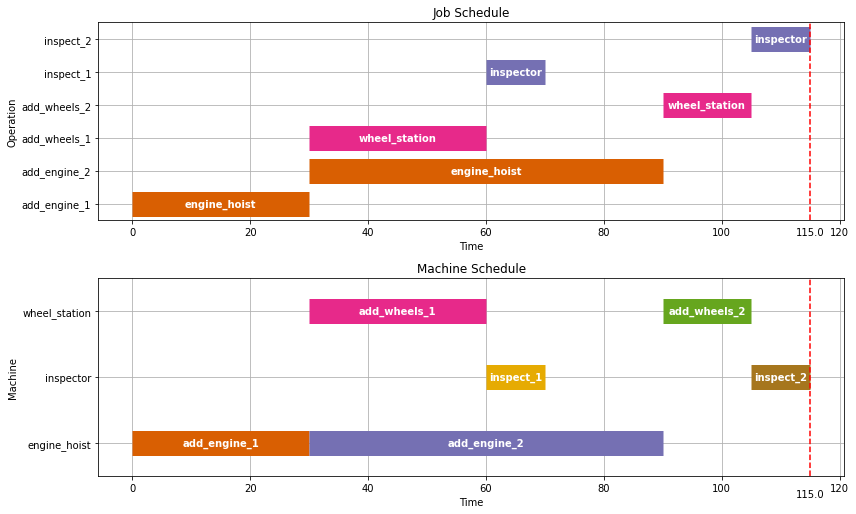

In [10]:
best_schedule = state_space_search(machines, jobs)
gantt_chart(best_schedule)

We can see that the best schedule is the `schedule_1` with the makespan of 115.

## Computational Complexity <a name='complexity'></a>

---

Assume that there are $N$ jobs and $M$ machines. Each job has $M$ operations, each to be processed by a different machine. There are $NM$ operations in total.

At each state, there can be at most $N$ applicable actions, as each job can have a ready operation. In other words, each node in the search tree has $O(N)$ branches. 

Each action completes an operation. Thus, it takes $NM$ actions from the initial state to a goal state. In other words, the depth of the tree is $NM$.

<img src="img/jss-state-search.png" width=600 />

Therefore, to enumerate all the leaf nodes (goal states) of the search tree, one has to visit all the nodes in the search tree, which has a computational complexity of 

$$
O(1 + N + N^2 + \dots + N^{NM}) \approx O(N^{NM}).
$$

> **NOTE**: Different states and actions can lead to the same resultant state, as shown in the figure above. Therefore, if we can avoid expanding the same state repetitively, the computational complexity can be greatly reduced.



## Jobs with Different Operation Sequences <a name='diffop'></a>

---

In job shop scheduling, different jobs can have different operation sequences. For example, in the car manufacturing problem, we can have one job with the sequence of [`add_engine` $\rightarrow$ `add_wheels` $\rightarrow$ `inspect`], and another job with [`add_wheels` $\rightarrow$ `add_engine` $\rightarrow$ `inspect`].

The state space search can be directly applied to job shop scheduling with any operation sequences.

To show an example, we create a second job shop scheduling instance with different operation sequences in different jobs (i.e., `add_engine_2` and `add_wheels_2` are swapped in job 2):


| Job | Operation | Machine |  Duration |
| --- | --------- | ------- |  --------- |
| 1   | `add_engine_1` | `engine_hoist` | 30 |
|     | `add_wheels_1` | `wheel_station` | 30 |
|     | `inspect_1` |    `inspector` | 10 |
| 2   | `add_wheels_2` | `wheel_station` | 15 |
|     | `add_engine_2` | `engine_hoist` | 60 |
|     | `inspect_2` |    `inspector` | 10 |

We create the second job shop as follows.

In [11]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

job_1 = [
    {'name': 'add_engine_1', 'machine': 'engine_hoist', 'duration': 30, 'next': 'add_wheels_1'},
    {'name': 'add_wheels_1', 'machine': 'wheel_station', 'duration': 30, 'next': 'inspect_1'},
    {'name': 'inspect_1', 'machine': 'inspector', 'duration': 10, 'next': None}
]

job_2 = [
    {'name': 'add_wheels_2', 'machine': 'wheel_station', 'duration': 15, 'next': 'add_engine_2'},
    {'name': 'add_engine_2', 'machine': 'engine_hoist', 'duration': 60, 'next': 'inspect_2'},    
    {'name': 'inspect_2', 'machine': 'inspector', 'duration': 10, 'next': None}
]

jobs = [job_1, job_2]

We can directly use the state space search algorithm to find the best schedule for the second job shop, and visualise its gantt chart.

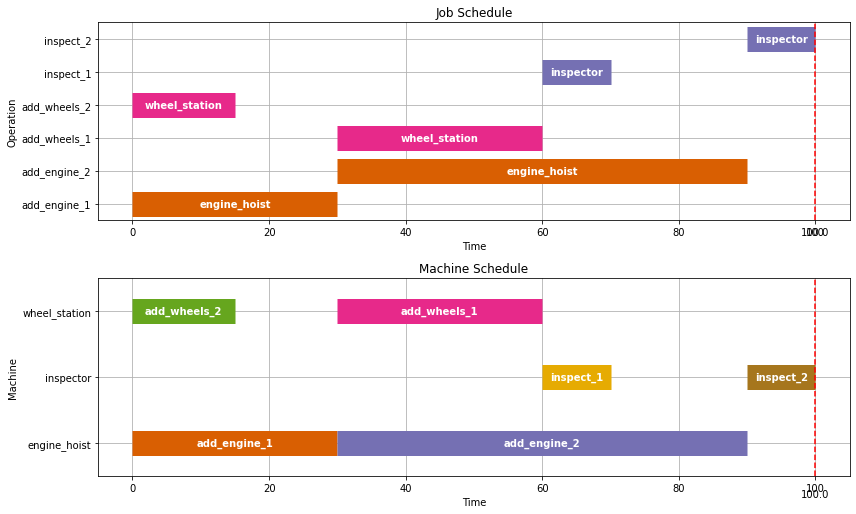

In [12]:
schedule_2 = state_space_search(machines, jobs)
gantt_chart(schedule_2)

We can see that the best schedule of the second job shop has a smaller makespan than the first one (100 vs 115). This is because the machines can be utilised better (e.g., `engine_hoist` and `wheel_station` can start processing at the beginning) due to the different operation sequences.

----

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)